Students:

- ...
- ...
- ...

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 6


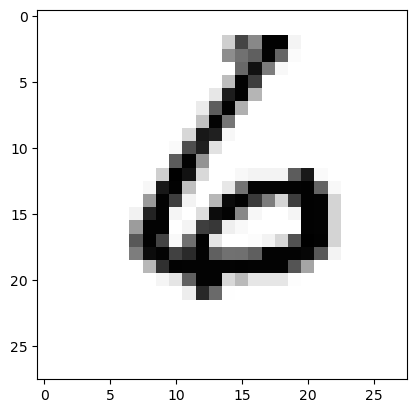

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            print(gradient, self.data)
            print(gradient.shape, self.data.shape)
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, (float, int)):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        if self.d is not None:
            self.d(self.backptr, self.gradient)

        if self.backptr is not None:
            for o in self.backptr:
                if isinstance(o, Tensor) and not isinstance(o, Parameter):
                    if o.require_grad:
                        o.backward()
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [8]:
def tanh(x):
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    if x.require_grad:
        x.accumulate_gradient(g * (1 - np.tanh(x.data)**2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
    v = W.data@x.data + b.data
    
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    
    return output

def backward_affine_transform(backptr, g):
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        if isinstance(x, Tensor):
            x_val = x.data
        else:
            x_val = x
        
        if len(x_val.shape) == 1:
            x_val = x_val.reshape(-1, 1)

        if len(g.shape) == 1:
            g = g.reshape(-1, 1)
            
        W.accumulate_gradient(g@x_val.T)

    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(W.data.T@g)

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    b = np.max(x)
    e = np.exp(x-b)
    return e/np.sum(e)

def nll(x, gold):
    data = -x.data.flatten()[gold] + np.log(np.sum(np.exp(x.data.flatten())))

    output = Tensor(data, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x, gold]

    return output


def backward_nll(backptr, g):
    x, gold = backptr

    if x.require_grad:
        x.accumulate_gradient(g*(-np.eye(len(x.data.flatten()))[gold]+_softmax(x.data.flatten())).reshape(-1, 1))
    

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
    def __init__(self):
        pass
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret
    
    def __call__(self, x):
        return self.forward(x)

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [12]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[0] + W.shape[1])), np.sqrt(6. / (W.shape[0] + W.shape[1])), W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / W.shape[1]), np.sqrt(6. / W.shape[1]), W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [14]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,1)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
    
    for epoch in range(n_epochs):
        print('EPOCH:', epoch+1)
        train_loss = 0
        train_good = 0
        for x, y in zip(*train_data):
            output = network(x.reshape(-1, 1))
            loss = nll(output, y)
            loss.backward(1)
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.data
            if np.argmax(output.data) == y:
                train_good += 1
        print('Training loss', train_loss/len(train_data[1]))
        print('Training accuracy', train_good/len(train_data[1]))

        dev_loss = 0
        dev_good = 0
        for x, y in zip(*dev_data):
            output = network(x.reshape(-1,1))
            loss = nll(output, y)
            dev_loss += loss.data
            if np.argmax(output.data) == y:
                dev_good += 1
        print('Validation loss', dev_loss/len(dev_data[1]))
        print('Validation accuracy', dev_good/len(dev_data[1]))
    

In [16]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

EPOCH: 1
Training loss [0.37627126]
Training accuracy 0.89166
Validation loss [0.29061843]
Validation accuracy 0.918
EPOCH: 2
Training loss [0.31034856]
Training accuracy 0.91136
Validation loss [0.27786517]
Validation accuracy 0.923
EPOCH: 3
Training loss [0.29790647]
Training accuracy 0.9146
Validation loss [0.27342691]
Validation accuracy 0.9241
EPOCH: 4
Training loss [0.29079467]
Training accuracy 0.91684
Validation loss [0.27139515]
Validation accuracy 0.9242
EPOCH: 5
Training loss [0.28586415]
Training accuracy 0.91866
Validation loss [0.27039511]
Validation accuracy 0.9255


After you finished the linear network, you can move to a deep network!

In [17]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh=False):

        self.input_proj = self.give_weight_matrix(dim_input, hidden_dim, 0)
        self.input_bias = self.give_bias(hidden_dim, 0)

        self.W = ModuleList([self.give_weight_matrix(hidden_dim, hidden_dim, i) for i in range(1, n_layers)])
        self.b = ModuleList([self.give_bias(hidden_dim, i) for i in range(1, n_layers)])
        
        
        self.output_proj = self.give_weight_matrix(hidden_dim, dim_output, n_layers)
        self.output_bias = self.give_bias(dim_output, n_layers)
        
        self.init_parameters()

        
    def init_parameters(self):
        zero_init(self.input_bias.data)
        zero_init(self.output_bias.data)
        for b in self.b:
            zero_init(b.data)

        glorot_init(self.input_proj.data)
        glorot_init(self.output_proj.data)
        for W in self.W:
            glorot_init(W.data)

    def forward(self, x):
        x = affine_transform(self.input_proj, self.input_bias, x)
        x = relu(x)
        for W, b in zip(self.W, self.b):
            x = affine_transform(W, b, x)
            x = relu(x)
        x = affine_transform(self.output_proj, self.output_bias, x)
        return x

    @staticmethod
    def give_weight_matrix(dim_input, dim_output, n):
        W = Parameter(np.ndarray((dim_output, dim_input)), name=f"W_{n}")
        return W
    
    @staticmethod
    def give_bias(dim, n):
        W = Parameter(np.ndarray((dim, 1)), name=f"b_{n}")
        return W

In [18]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

EPOCH: 1
Training loss [0.24918737]
Training accuracy 0.9231
Validation loss [0.1269965]
Validation accuracy 0.9628
EPOCH: 2
Training loss [0.11580073]
Training accuracy 0.96506
Validation loss [0.11242589]
Validation accuracy 0.9686
EPOCH: 3
Training loss [0.08125067]
Training accuracy 0.97512
Validation loss [0.10460794]
Validation accuracy 0.9718
EPOCH: 4
Training loss [0.06294522]
Training accuracy 0.98072
Validation loss [0.11897714]
Validation accuracy 0.9671
EPOCH: 5
Training loss [0.0538841]
Training accuracy 0.98232
Validation loss [0.11334468]
Validation accuracy 0.9702


## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [26]:
class MomentumSGD:
    def __init__(self, params, lr=0.1, momentum=0.1):
        self.params = params
        self.velocities = [np.zeros_like(p.data) for p in params]
        self.lr = lr
        self.momentum = momentum

    def step(self):
        for p, velocity in zip(self.params, self.velocities):
            velocity[:] = self.momentum * velocity + p.gradient
            p.data[:] = p.data - self.lr * velocity
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

In [27]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = MomentumSGD(network.parameters(), 0.01, momentum=0.1)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

EPOCH: 1
Training loss [0.24787806]
Training accuracy 0.92328
Validation loss [0.1285585]
Validation accuracy 0.9619
EPOCH: 2
Training loss [0.11850497]
Training accuracy 0.9645
Validation loss [0.11971927]
Validation accuracy 0.9645
EPOCH: 3
Training loss [0.08214556]
Training accuracy 0.97446
Validation loss [0.11153357]
Validation accuracy 0.9683
EPOCH: 4
Training loss [0.06429762]
Training accuracy 0.98004
Validation loss [0.117301]
Validation accuracy 0.9681
EPOCH: 5
Training loss [0.05352035]
Training accuracy 0.98256
Validation loss [0.12524923]
Validation accuracy 0.968
